### ssGSEA analysis on data from TCGA-SKCM dataset

In [1]:
library(matrixStats)
library(circlize)
library(ComplexHeatmap)
library(data.table)
library(SummarizedExperiment)
library(S4Vectors)
library(GenomicRanges)
library(IRanges)
library(dplyr)

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps in

In [2]:
#set working directory (location where TCGA data is stored)
setwd("/scratch/user/s4436039/TCGA_Data")

In [3]:
# load in data (data was previously downloaded using the TCGAbiolinks package in R and saved as an RDS object)
TCGA_OV <- readRDS("TCGA-OV.RDS")
TCGA_OV
summary(TCGA_OV)

class: RangedSummarizedExperiment 
dim: 60660 429 
metadata(1): data_release
assays(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand
rownames(60660): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000288674.1 ENSG00000288675.1
rowData names(10): source type ... hgnc_id havana_gene
colnames(429): TCGA-10-0933-01A-01R-1569-13
  TCGA-23-1024-01A-02R-1564-13 ... TCGA-13-0891-01A-01R-1564-13
  TCGA-24-1842-01A-01R-1567-13
colData names(63): barcode patient ... days_to_sample_procurement
  sample.aux

[1] "RangedSummarizedExperiment object of length 60660 with 10 metadata columns"

In [4]:
unique(TCGA_OV$sample_type)

[1] "Primary Tumor"   "Recurrent Tumor"

In [5]:
table(colData(TCGA_OV)$sample_type)


  Primary Tumor Recurrent Tumor 
            421               8 

In [6]:
#define SSGSEA Function
#function from https://rpubs.com/pranali018/SSGSEA  

ssgsea = function(X, gene_sets, alpha = 0.25, scale = T, norm = F, single = T) {
  row_names = rownames(X)
  num_genes = nrow(X)
  gene_sets = lapply(gene_sets, function(genes) {which(row_names %in% genes)})
  
  # Ranks for genes
  R = matrixStats::colRanks(X, preserveShape = T, ties.method = 'average')
  
  # Calculate enrichment score (es) for each sample (column)
  es = apply(R, 2, function(R_col) {
    gene_ranks = order(R_col, decreasing = TRUE)
    
    # Calc es for each gene set
    es_sample = sapply(gene_sets, function(gene_set_idx) {
      # pos: match (within the gene set)
      # neg: non-match (outside the gene set)
      indicator_pos = gene_ranks %in% gene_set_idx
      indicator_neg = !indicator_pos
      
      rank_alpha  = (R_col[gene_ranks] * indicator_pos) ^ alpha
      
      step_cdf_pos = cumsum(rank_alpha)    / sum(rank_alpha)
      step_cdf_neg = cumsum(indicator_neg) / sum(indicator_neg)
      
      step_cdf_diff = step_cdf_pos - step_cdf_neg
      
      # Normalize by gene number
      if (scale) step_cdf_diff = step_cdf_diff / num_genes
      
      # Use ssGSEA or not
      if (single) {
        sum(step_cdf_diff)
      } else {
        step_cdf_diff[which.max(abs(step_cdf_diff))]
      }
    })
    unlist(es_sample)
  })
  
  if (length(gene_sets) == 1) es = matrix(es, nrow = 1)
  
  # Normalize by absolute diff between max and min
  if (norm) es = es / diff(range(es))
  
  # Prepare output
  rownames(es) = names(gene_sets)
  colnames(es) = colnames(X)
  return(es)
}


In [7]:
#view the different assays stored
assays(TCGA_OV)

List of length 6
names(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand

In [8]:
#for this analysis using the tpm_unstrand assay 
dim(assays(TCGA_OV)$tpm_unstrand)
#set data to tpm_unstand assay for this analysis
data <- assays(TCGA_OV)$tpm_unstrand
#view data
data[1:3,1:3]

[1] 60660   429

,TCGA-10-0933-01A-01R-1569-13,TCGA-23-1024-01A-02R-1564-13,TCGA-13-0886-01A-01R-1569-13
ENSG00000000003.15,34.9136,40.8173,82.6270
ENSG00000000005.6,31.2364,0.1372,1.7904
ENSG00000000419.13,268.7763,175.1564,135.6695


In [9]:
#convert to matrix
data = as.matrix(data)

In [10]:
#load in my signature and make it a list (edit this to any signature)
sig <- fread("ag_pos_vs_dll1_deg_limma.csv", select = c("gene_id"))
sig <- sig[1:100,]
sig = as.list(as.data.frame(sig))
head(sig)

$gene_id
  [1] "ENSG00000102962.5"  "ENSG00000104951.16" "ENSG00000198053.12"
  [4] "ENSG00000126353.3"  "ENSG00000171310.11" "ENSG00000180758.12"
  [7] "ENSG00000090104.12" "ENSG00000023445.16" "ENSG00000056558.11"
 [10] "ENSG00000198223.17" "ENSG00000107021.16" "ENSG00000078081.8" 
 [13] "ENSG00000118242.16" "ENSG00000167641.11" "ENSG00000198369.10"
 [16] "ENSG00000112149.10" "ENSG00000136810.13" "ENSG00000172081.14"
 [19] "ENSG00000109320.13" "ENSG00000136111.14" "ENSG00000123374.11"
 [22] "ENSG00000261040.7"  "ENSG00000047365.12" "ENSG00000160445.11"
 [25] "ENSG00000151726.15" "ENSG00000167642.13" "ENSG00000161011.20"
 [28] "ENSG00000204634.13" "ENSG00000101384.12" "ENSG00000278834.1" 
 [31] "ENSG00000156127.8"  "ENSG00000117036.12" "ENSG00000171791.14"
 [34] "ENSG00000068796.19" "ENSG00000075618.18" "ENSG00000118503.15"
 [37] "ENSG00000160050.15" "ENSG00000119508.18" "ENSG00000115165.10"
 [40] "ENSG00000115956.10" "ENSG00000150907.10" "ENSG00000025772.8" 
 [43] "ENSG00000135148.12" "ENSG00000101445.10" "ENSG00000121966.7" 
 [46] "ENSG00000101017.14" "ENSG00000198018.7"  "ENSG00000124762.14"
 [49] "ENSG00000015475.19" "ENSG00000277443.3"  "ENSG00000138166.6" 
 [52] "ENSG00000071054.16" "ENSG00000171552.14" "ENSG00000172183.15"
 [55] "ENSG00000145860.12" "ENSG00000137522.18" "ENSG00000183484.12"
 [58] "ENSG00000138670.18" "ENSG00000197872.11" "ENSG00000084733.11"
 [61] "ENSG00000172292.15" "ENSG00000115594.12" "ENSG00000101109.12"
 [64] "ENSG00000069493.15" "ENSG00000217801.10" "ENSG00000177311.11"
 [67] "ENSG00000159128.15" "ENSG00000120217.14" "ENSG00000136052.9" 
 [70] "ENSG00000118257.17" "ENSG00000164236.12" "ENSG00000169508.7" 
 [73] "ENSG00000163389.12" "ENSG00000128271.22" "ENSG00000102221.14"
 [76] "ENSG00000131773.14" "ENSG00000168036.18" "ENSG00000137571.11"
 [79] "ENSG00000077150.20" "ENSG00000116741.8"  "ENSG00000106803.10"
 [82] "ENSG00000186187.12" "ENSG00000104856.14" "ENSG00000151131.11"
 [85] "ENSG00000168310.11" "ENSG00000273604.2"  "ENSG00000059728.11"
 [88] "ENSG00000111540.16" "ENSG00000117115.13" "ENSG00000136048.14"
 [91] "ENSG00000108389.9"  "ENSG00000103319.12" "ENSG00000111846.19"
 [94] "ENSG00000173166.18" "ENSG00000140379.9"  "ENSG00000101310.17"
 [97] "ENSG00000198355.5"  "ENSG00000163297.17" "ENSG00000166016.6" 
[100] "ENSG00000164484.12"

In [11]:
#Run ssGSEA function
#ssgsea: https://rpubs.com/pranali018/SSGSEA
system.time(assign('res', ssgsea(data, sig, scale = TRUE, norm = FALSE)))

   user  system elapsed 
  4.833   0.522   5.378 

In [12]:
#transpose results
res1 = t(res)
head(res1)

,gene_id
TCGA-10-0933-01A-01R-1569-13,0.3498763
TCGA-23-1024-01A-02R-1564-13,0.3510426
TCGA-13-0886-01A-01R-1569-13,0.3769945
TCGA-29-1769-01A-01R-1567-13,0.3628586
TCGA-13-1505-01A-01R-1565-13,0.3629343
TCGA-61-1736-01B-01R-1568-13,0.3781320


In [13]:
#calculate mat (ssGSEA Z score - ssgsea output for comparative analysis)
mat = (res - rowMeans(res))/(rowSds(as.matrix(res)))[row(res)]
dim(mat)
mat[1,1:5] 

[1]   1 429

TCGA-10-0933-01A-01R-1569-13 TCGA-23-1024-01A-02R-1564-13 
                  -1.0272381                   -0.9492666 
TCGA-13-0886-01A-01R-1569-13 TCGA-29-1769-01A-01R-1567-13 
                   0.7855929                   -0.1593829 
TCGA-13-1505-01A-01R-1565-13 
                  -0.1543182

#### at this point now have a score for each patient with how enriched that sample is for my signature, the ID here is the "barcode"
* next want to see how this score correlates with survival etc

In [14]:
#to view the types of data stored for each sample 
colnames(colData(TCGA_OV))

[1] "barcode"                     "patient"                    
 [3] "sample"                      "shortLetterCode"            
 [5] "definition"                  "sample_submitter_id"        
 [7] "sample_type_id"              "tumor_descriptor"           
 [9] "sample_id"                   "sample_type"                
[11] "composition"                 "state"                      
[13] "intermediate_dimension"      "pathology_report_uuid"      
[15] "submitter_id"                "shortest_dimension"         
[17] "longest_dimension"           "is_ffpe"                    
[19] "tissue_type"                 "figo_stage"                 
[21] "synchronous_malignancy"      "days_to_diagnosis"          
[23] "treatments"                  "last_known_disease_status"  
[25] "tissue_or_organ_of_origin"   "days_to_last_follow_up"     
[27] "age_at_diagnosis"            "primary_diagnosis"          
[29] "prior_malignancy"            "year_of_diagnosis"          
[31] "prior_treatment"             "morphology"                 
[33] "classification_of_tumor"     "diagnosis_id"               
[35] "icd_10_code"                 "site_of_resection_or_biopsy"
[37] "tumor_grade"                 "progression_or_recurrence"  
[39] "alcohol_history"             "exposure_id"                
[41] "race"                        "gender"                     
[43] "ethnicity"                   "vital_status"               
[45] "age_at_index"                "days_to_birth"              
[47] "year_of_birth"               "demographic_id"             
[49] "days_to_death"               "year_of_death"              
[51] "bcr_patient_barcode"         "primary_site"               
[53] "project_id"                  "disease_type"               
[55] "name"                        "releasable"                 
[57] "released"                    "days_to_collection"         
[59] "initial_weight"              "oct_embedded"               
[61] "preservation_method"         "days_to_sample_procurement" 
[63] "sample.aux"

In [15]:
#change column name
mat <- t(mat)
dim(mat)
colnames(mat) <- c("mat")
head(mat)

[1] 429   1

,mat
TCGA-10-0933-01A-01R-1569-13,-1.0272381
TCGA-23-1024-01A-02R-1564-13,-0.9492666
TCGA-13-0886-01A-01R-1569-13,0.7855929
TCGA-29-1769-01A-01R-1567-13,-0.1593829
TCGA-13-1505-01A-01R-1565-13,-0.1543182
TCGA-61-1736-01B-01R-1568-13,0.8616316


In [16]:
#now look at days to death, plot K-M curved grouped by groups of mat score 
###following this tutorial: https://www.youtube.com/watch?v=DnygUTAZFmM

#making a matrix with all the data I need
death_days <- colData(TCGA_OV)$days_to_death
names(death_days) <- row.names(colData(TCGA_OV))
followup_days <- colData(TCGA_OV)$days_to_last_follow_up
names(followup_days) <- row.names(colData(TCGA_OV))
status <- colData(TCGA_OV)$vital_status
names(status) <- row.names(colData(TCGA_OV))

concat_survival <- cbind(mat,followup_days,status,death_days)
colnames(concat_survival) <- c("mat","Days_to_last_follow_up","vital_status","days_to_death")
head(concat_survival) 
concat_survival <- as.data.frame(concat_survival)
#now I have a table with the above variables for each patient

,mat,Days_to_last_follow_up,vital_status,days_to_death
TCGA-10-0933-01A-01R-1569-13,-1.02723808138905,356,Dead,446
TCGA-23-1024-01A-02R-1564-13,-0.949266567913379,468,Alive,NA
TCGA-13-0886-01A-01R-1569-13,0.785592936164453,4665,Alive,NA
TCGA-29-1769-01A-01R-1567-13,-0.159382866079816,699,Alive,NA
TCGA-13-1505-01A-01R-1565-13,-0.154318191959511,1998,Alive,NA
TCGA-61-1736-01B-01R-1568-13,0.861631631325787,1484,Dead,1484


In [17]:
#make a new column that records whether or not deceased, this will be needed for status in survival anakysis (for censoring)
concat_survival$deceased <- ifelse(concat_survival$vital_status == "Alive", FALSE, TRUE)
head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased
,<chr>,<chr>,<chr>,<chr>,<lgl>
TCGA-10-0933-01A-01R-1569-13,-1.02723808138905,356,Dead,446,TRUE
TCGA-23-1024-01A-02R-1564-13,-0.949266567913379,468,Alive,NA,FALSE
TCGA-13-0886-01A-01R-1569-13,0.785592936164453,4665,Alive,NA,FALSE
TCGA-29-1769-01A-01R-1567-13,-0.159382866079816,699,Alive,NA,FALSE
TCGA-13-1505-01A-01R-1565-13,-0.154318191959511,1998,Alive,NA,FALSE
TCGA-61-1736-01B-01R-1568-13,0.861631631325787,1484,Dead,1484,TRUE


In [18]:
#next need to make a "overall survival" column that is equal to days to death for dead patients and to days to last follow up for patients who are still alive 
concat_survival$overall_survival <- ifelse(concat_survival$vital_status == "Alive",
                                           concat_survival$Days_to_last_follow_up,
                                           concat_survival$days_to_death)

#convert overall_survival to numeric
concat_survival$overall_survival <- as.numeric(concat_survival$overall_survival)

head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
TCGA-10-0933-01A-01R-1569-13,-1.02723808138905,356,Dead,446,TRUE,446
TCGA-23-1024-01A-02R-1564-13,-0.949266567913379,468,Alive,NA,FALSE,468
TCGA-13-0886-01A-01R-1569-13,0.785592936164453,4665,Alive,NA,FALSE,4665
TCGA-29-1769-01A-01R-1567-13,-0.159382866079816,699,Alive,NA,FALSE,699
TCGA-13-1505-01A-01R-1565-13,-0.154318191959511,1998,Alive,NA,FALSE,1998
TCGA-61-1736-01B-01R-1568-13,0.861631631325787,1484,Dead,1484,TRUE,1484


In [19]:
# load packages needed for survival analysis
library(survival)
library(survminer)

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [20]:
#fitting survival curve - prepare data: 

# for my analysis I wanted to plot top vs bottom third on my KM plot, but could also split 50/50 if you wanted
# make variable for either top 33% or bottom 33% mat score
#calculate 66th percentile (above this is top 33%) and 33rd percentile (below this is bottom 33%)
perc_66 <- quantile(mat, probs = c(0.66))
perc_33 <- quantile(mat, probs = c(0.33))

concat_survival_Full <- concat_survival
concat_survival_Full$strata <- ifelse(concat_survival_Full$mat < perc_33, "Bottom 33%",
                                  ifelse(concat_survival_Full$mat >perc_66, "Top 33%", "Middle"))

head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-10-0933-01A-01R-1569-13,-1.02723808138905,356,Dead,446,TRUE,446,Middle
TCGA-23-1024-01A-02R-1564-13,-0.949266567913379,468,Alive,NA,FALSE,468,Middle
TCGA-13-0886-01A-01R-1569-13,0.785592936164453,4665,Alive,NA,FALSE,4665,Top 33%
TCGA-29-1769-01A-01R-1567-13,-0.159382866079816,699,Alive,NA,FALSE,699,Bottom 33%
TCGA-13-1505-01A-01R-1565-13,-0.154318191959511,1998,Alive,NA,FALSE,1998,Bottom 33%
TCGA-61-1736-01B-01R-1568-13,0.861631631325787,1484,Dead,1484,TRUE,1484,Top 33%


In [21]:
#need to remove middle strata from plot
concat_survival_Full <- concat_survival_Full %>% filter(strata %in% c("Top 33%", "Bottom 33%"))
head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-13-0886-01A-01R-1569-13,0.785592936164453,4665,Alive,NA,FALSE,4665,Top 33%
TCGA-29-1769-01A-01R-1567-13,-0.159382866079816,699,Alive,NA,FALSE,699,Bottom 33%
TCGA-13-1505-01A-01R-1565-13,-0.154318191959511,1998,Alive,NA,FALSE,1998,Bottom 33%
TCGA-61-1736-01B-01R-1568-13,0.861631631325787,1484,Dead,1484,TRUE,1484,Top 33%
TCGA-61-1737-01A-01R-1567-13,0.7877060323791,1364,Alive,NA,FALSE,1364,Top 33%
TCGA-29-1705-02A-01R-1567-13,1.30717233015406,555,Dead,555,TRUE,555,Top 33%


In [22]:
#Fit survival curve
fit <- survfit(Surv(overall_survival, deceased) ~ strata, data = concat_survival_Full)
fit

Call: survfit(formula = Surv(overall_survival, deceased) ~ strata, 
    data = concat_survival_Full)

   1 observation deleted due to missingness 
                    n events median 0.95LCL 0.95UCL
strata=Bottom 33%  47     30   1259    1169    2028
strata=Top 33%    145     86   1384    1187    1721

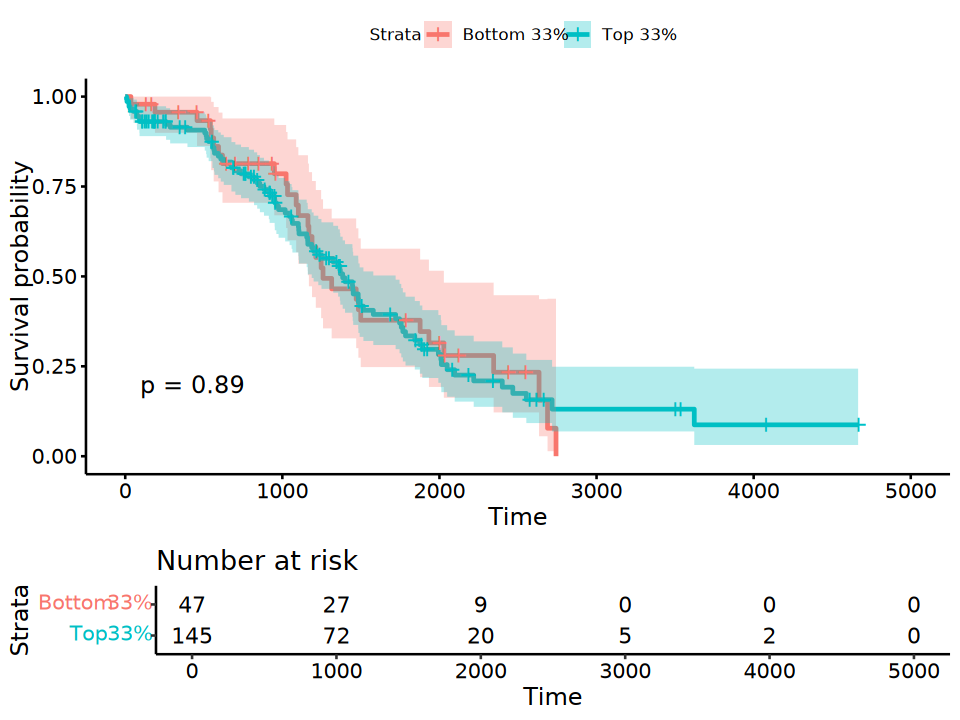

In [23]:
#generate survival plot
options(repr.plot.height=6, repr.plot.width=8)
ggsurvplot(fit,
           data = concat_survival_Full,
           pval = T,
           risk.table = T,
           conf.int = TRUE)